In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

from keras_preprocessing.text import Tokenizer
from gensim.models import KeyedVectors
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.layers import Embedding
from keras.initializers import Constant
from keras.callbacks import EarlyStopping

# NOTAM Text Classification with BERT
This notebook explores classifying NOTAM data using a neural network with a Word2Vec word embedding and a LSTM. It uses airport_notams.xls as its data source, which is a compilation of 6897 NOTAMs from the 10 US airports with the highest traffic. The NOTAMs from each individual airport were retreived from the official [FAA website](https://notams.aim.faa.gov/notamSearch/nsapp.html#/) using the 100 mile location filter.

The embedding layer uses a prebuilt word embedding _wiki-news-300d-1M.vec_ from Google. Prior to training, invalid NOTAMs are filtered out and a set of NOTAM-specific acronyms are translated into English words. The neural network uses a 80-20 split for training and validation data, and is trained with early stopping patience 3, batch size 10, and 50 epochs. The model is saved under a directory _model_word2vec/_.

The validation accuracies are fairly low in this model. This is likely because the Google word embedding vector does not include significant portions of the NOTAM jargon. The notebook uses a small dictionary to translate some acronyms to English words, but this could be expanded to improve accuracies. Additionally, a custom word embedding vector could be created using the data to help improve training (see [this tutorial](https://www.kaggle.com/code/chewzy/tutorial-how-to-train-your-custom-word-embedding))

In [56]:
# Helper functions

# Returns average, minimum, and maximum lengths of text
def get_lengths(data):
    avg_len, min_len, max_len = 0, np.inf, -1
    for example in data:
        length = len(example)
        avg_len += length
        if length < min_len:
            min_len = length
        if length > max_len:
            max_len = length
    avg_len /= len(data)
    return avg_len, min_len, max_len

# Creates a pie chart of the distribution of labels
def plot_distribution(data):
    counts = {}
    for example in data:
        if example in counts:
            counts[example] += 1
        else:
            counts[example] = 1
    plt.pie(counts.values(), labels=counts.keys())
    plt.show()

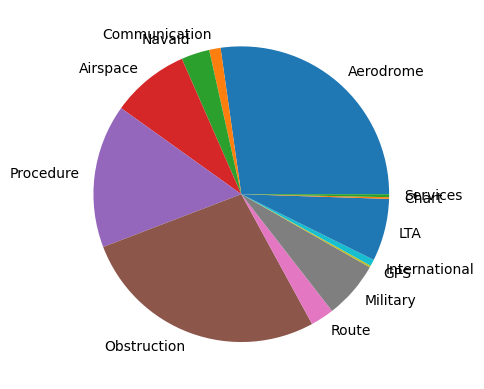

Average length: 192.40572571956287 
Min length: 14 
Max length: 13468


In [87]:
MAX_LENGTH = 13468

df = pd.read_excel("./airport_notams.xls")
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)

raw_labels = df["Class"].values.tolist()
raw_text = df["NOTAM Condition/LTA subject/Construction graphic title"].values.tolist()
plot_distribution(raw_labels)

ohe = pd.get_dummies(raw_labels)
df = pd.concat([df["NOTAM Condition/LTA subject/Construction graphic title"], ohe], axis=1)

lengths = get_lengths(df["NOTAM Condition/LTA subject/Construction graphic title"])
print(f"Average length: {lengths[0]} \nMin length: {lengths[1]} \nMax length: {lengths[2]}")

In [98]:
# Helper functions

VALIDATION_SPLIT=0.2
valid_keywords = {
    "RWY": "Runway",
    "TWY": "Taxiway",
    "APRON": "Apron",
    "AD": "Aerodrome",
    "OBST": "Obstruction",
    "NAV": "Navigation",
    "COM": "Communication",
    "SVC": "Service",
    "AIRSPACE": "Airspace"
}

# Normalize text
def normalize_text(text, labels):
    filtered = []
    filtered_labels = []
    text = [t.replace("\n", " ") for t in text]
    for i, t in enumerate(text):
        if not re.match("![a-zA-Z]* [0-9]*/[0-9]*", t[:11]):
            continue
        for v in valid_keywords:
            if v in t:
                t.replace(v, valid_keywords[v])
                filtered.append("".join([t for t in t.lower() if t.isalnum() or t == " "]))
                filtered_labels.append(labels[i])
                break
    return filtered, filtered_labels

# Split the data into a training set and a validation set
def split_data(padded_sequences, labels, validation_split=VALIDATION_SPLIT):
    indices = np.arange(padded_sequences.shape[0])
    np.random.shuffle(indices)
    padded_sequences = padded_sequences[indices]
    labels = labels[indices]
    num_validation_samples = int(validation_split * padded_sequences.shape[0])

    X_train_pad = padded_sequences[:-num_validation_samples]
    y_train = labels[:-num_validation_samples]
    X_test_pad = padded_sequences[-num_validation_samples:]
    y_test = labels[-num_validation_samples:]
    
    return X_train_pad, y_train, X_test_pad, y_test

# Return the word embedding matrix
def get_embedding_matrix(word_index, embedding_dim, trained_embedding_dictionary):
    num_words = len(word_index) + 1
    embedding_matrix = np.zeros((num_words, embedding_dim))

    for word, i in word_index.items():
        if i > num_words:
            continue
        embedding_vector = trained_embedding_dictionary.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    return embedding_matrix, num_words

# Train the model
def train(num_words, embedding_matrix, data, num_outputs, batch_size, epochs, max_length, embedding_dim, callbacks=[]):
    model = Sequential()
    embedding_layer = Embedding(num_words,
                                embedding_dim,
                                embeddings_initializer=Constant(embedding_matrix),
                                input_length=max_length,
                                trainable=False)
    model.add(embedding_layer)
    model.add(LSTM(units=32,  dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(num_outputs, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    print('Summary of the built model...')
    print(model.summary())

    X_train_pad, y_train, X_test_pad, y_test = data
    history = model.fit(X_train_pad, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test_pad, y_test), callbacks=callbacks, verbose=2)
    
    return model, history

# Summarize history for accuracy and loss
def plot_accuracy_loss(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()


In [63]:
# Helper functions

WORD2VEC_EMBEDDING_DIM = 300

# Tokenize the text
def tokenize_text(cleaned_data):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(cleaned_data)
    word_index = tokenizer.word_index
    print('Found %s unique tokens.' % len(word_index))
    return word_index, tokenizer

# Predict label for text
def test_model(model, encoding, tokenizer, max_length, text):
  # removes punctuation in the sentence
  text = re.sub(r'[^\w\s]', '', text)
  # gets all of the words in the sentence 
  words = word_tokenize(text) 
  # converts all the words to lowercase
  words = [w.lower() for w in words]
  # retrieves a set of all of the stopwords in English 
  stop_words = set(stopwords.words('english'))
  # removes the stopwords in the sentence
  words = [w for w in words if not w in stop_words]

  sequences = tokenizer.texts_to_sequences([words])
  review_pad = pad_sequences(sequences, maxlen=max_length)
    
  probabilities = model.predict(review_pad, verbose=0)
  prediction = np.argmax(probabilities)

  return f'{encoding[prediction]} with probability {probabilities[0][prediction] * 100}%'

# Use word2vec and get pretrained word embeddings 
# https://code.google.com/archive/p/word2vec/
word2vec_model = KeyedVectors.load_word2vec_format('../wiki-news-300d-1M.vec')
word2vec_embedding_dict = {}

for x in word2vec_model.key_to_index:
  word2vec_embedding_dict[x] = word2vec_model.get_vector(x)

In [99]:
text, labels = normalize_text(raw_text, raw_labels)

word_index, notam_tokenizer = tokenize_text(text)
embedding_matrix, num_words = get_embedding_matrix(word_index, WORD2VEC_EMBEDDING_DIM, word2vec_embedding_dict)

sequences = notam_tokenizer.texts_to_sequences(text)

sentences = pad_sequences(sequences, maxlen=MAX_LENGTH)
labels = np.array((df['Aerodrome'].values, df['Airspace'].values, df['Chart'].values, df['Communication'].values, df['GPS'].values, 
                  df['International'].values, df['LTA'].values, df['Military'].values, df['Navaid'].values, df['Obstruction'].values, df['Procedure'].values,
                  df['Route'].values, df['Services'].values)).T

data = split_data(sentences, labels)

Found 20236 unique tokens.


In [100]:
# Train the model
es = EarlyStopping(
        monitor="val_loss",
        patience=3,
        restore_best_weights=True,
    )

model_word2vec, history_word2vec = train(num_words, embedding_matrix, data, num_outputs=13, batch_size=10, epochs=50, max_length=MAX_LENGTH, embedding_dim=WORD2VEC_EMBEDDING_DIM, callbacks=[es])

model_word2vec.save('model_word2vec')

Summary of the built model...
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 13468, 300)        6071100   
                                                                 
 lstm_5 (LSTM)               (None, 32)                42624     
                                                                 
 dense_5 (Dense)             (None, 13)                429       
                                                                 
Total params: 6,114,153
Trainable params: 43,053
Non-trainable params: 6,071,100
_________________________________________________________________
None
Epoch 1/50
431/431 - 5047s - loss: 1.9449 - accuracy: 0.2787 - val_loss: 1.8728 - val_accuracy: 0.3088 - 5047s/epoch - 12s/step
Epoch 2/50
431/431 - 5027s - loss: 1.8878 - accuracy: 0.2917 - val_loss: 1.8666 - val_accuracy: 0.2949 - 5027s/epoch - 12s/step
Epoch 3/50
4

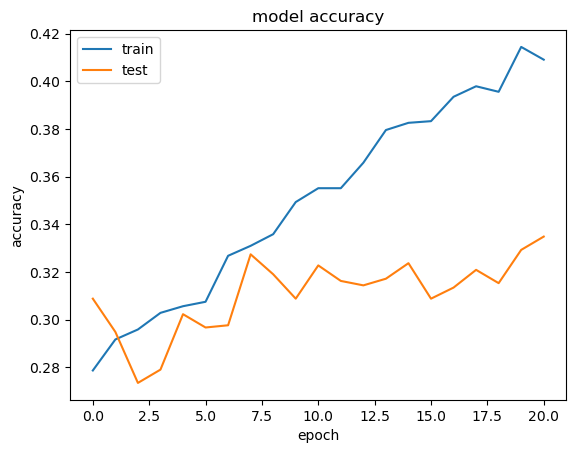

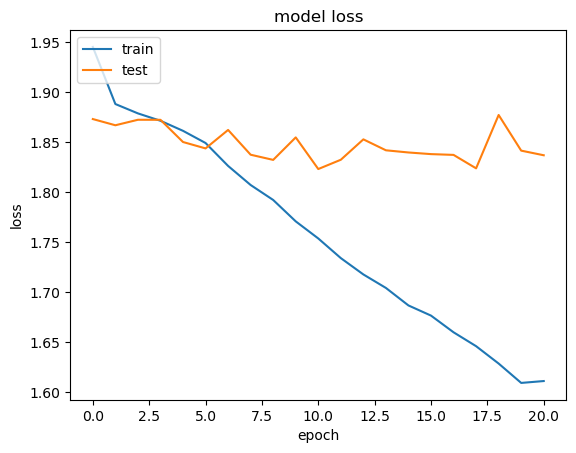

In [101]:
plot_accuracy_loss(history_word2vec)